Anexo P

# Red Neuronal Convolucional GoogleNet

#### Elaborado por: Ricardo Niño de Rivera Barrón

#### Ingeniería Biónica

#### Trabajo Terminal II

En esta libreta interactiva se describe el proceso para la implementación de un modelo de Red Neuronal Convolucional llamado GoogleNet.

Esta libreta se desarrolló en la plaforma Kaggle con el objetivo de mejorar la velocidad de implementación.

In [1]:
# Importando bibliotecas necesarias
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib.image as mpimg
import sklearn
import tensorflow as tf

Ahora instalamos una nueva biblioteca para poder descargar archivos de MEGA.

In [2]:
# Instalanado mega.py
!pip install mega.py

     |████████████████████████████████| 13.7 MB 7.9 MB/s 
     |████████████████████████████████| 49 kB 4.1 MB/s 
  Created wheel for pathlib: filename=pathlib-1.0.1-py3-none-any.whl size=14346 sha256=f115ca4b07e4940c5c028fe60c8cc51d71c18c74e622d3aeb0099e92829e4d67
  Stored in directory: /root/.cache/pip/wheels/6e/96/b8/10037fe231e23970bac58361d7c93571ab983a7bbc55e68550
Successfully built pathlib
  Attempting uninstall: tenacity
    Found existing installation: tenacity 6.1.0
    Uninstalling tenacity-6.1.0:
      Successfully uninstalled tenacity-6.1.0


In [3]:
# De la biblioteca mega importamos el método Mega
from mega import Mega

In [4]:
# Instanciando Mega en el objeto mega
mega = Mega()

Inicamos sesión en MEGA con cuenta temporal y anónima

In [5]:
# Log in en la cuenta de MEGA con cuenta temporal anónima
m = mega.login()

Descargando Base de Datos.

In [6]:
# Descargando Base de Datos
m.download_url('https://mega.nz/file/dBARgAIQ#uiQq4P-zC1fm6tV1I_udl2dtCiqzwyDadLyVlZ_dzAY')

PosixPath('BaseDeDatosFrontales_FINAL_256_bits.zip')

Como Kaggle es un entorno de desarrollo que trabaja en Linux utilizaremos algunos comandos nativos de este sistema operativo.

Para descomprimir el archivo utilizarmos el comando nativo de Linux <em>unzip</em>.



In [7]:
!unzip -q BaseDeDatosFrontales_FINAL_256_bits.zip

Descargamos los archivos necesarios.



In [8]:
# Descargando pos_train
m.download_url('https://mega.nz/file/Fcp12QzD#MLUFNaNeKJ8YFPo2bO1uNt7hnKCbDAy8S10s1-vKJ5Q')

PosixPath('pos_train.npy')

In [9]:
# Descargando pos_test
m.download_url('https://mega.nz/file/sQoFDaRB#Uh70-XjrqlGKaE9eBoc4puXnNxNFcQ0D23h_79rDnC4')

PosixPath('pos_test.npy')

In [10]:
# Descargando Y_train2.npy
m.download_url('https://mega.nz/file/tdohXarb#SRrt31GIT7H6gioCVm2KYF-sH6a8PHK8Z7Tr76oZb4I')

PosixPath('Y_train2.npy')

In [11]:
# Descargando Y_test2.npy
m.download_url('https://mega.nz/file/Vc5TBSbY#D8pbUvpA3l2V0PJxCu7Meg8WJ3wPpT6X2jEoDsleCWw')

PosixPath('Y_test2.npy')

Ahora se leen los archivos con numpy

In [12]:
pos_train = np.load('pos_train.npy')
pos_train.shape

(3337,)

In [13]:
pos_test = np.load('pos_test.npy')
pos_test.shape

(832,)

In [14]:
Y_train = np.load('Y_train2.npy')
Y_train.shape

(3337,)

In [15]:
# Agregando un dimensión para evitar errores con tensorflow
#Y_train = np.expand_dims(Y_train, axis=1)
#Y_train.shape

In [16]:
Y_test = np.load('Y_test2.npy')
Y_test.shape

(832,)

In [17]:
# Agregando un dimensión para evitar errores con tensorflow
#Y_test = np.expand_dims(Y_test, axis=1)
#Y_test.shape

Leemos los archivos en los directorios de interés.

In [18]:
# Leyendo archivos de entrenamiento
files=os.listdir("./BaseDeDatosFrontales_FINAL_256_bits/train")

In [19]:
# Leyendo archivos de validación
files2=os.listdir("./BaseDeDatosFrontales_FINAL_256_bits/test")

In [20]:
# Ordenando alfabeticamente el contenido de las listas
files.sort()
files2.sort()

### Construyendo X_train y X_test

Vamos a definir un nuevo tamaño de las imágenes para evitar problemas de memoria y acelerar el entrenamiento.

In [21]:
size_img = 128

In [22]:
# Definiendo función get_img para leer los archivos numpy y ajustarlos a nuevo tamaño.
# La imagen que retorna la función también es normalizada sobre los valor máximo del pixel (255)
def get_img(path, size, display_image = False):
  img = np.load(path)
  img = np.expand_dims(img, axis=2)
  if display_image == True:
    print(img.shape)
    plt.imshow(img[:,:,0], cmap='hot')

  return tf.image.resize(img, [size,size], antialias=True)/255

In [23]:
# Directorio raíz
path = "./BaseDeDatosFrontales_FINAL_256_bits/"

Realizamos una prueba de funcionamiento de la función

(480, 640, 1)


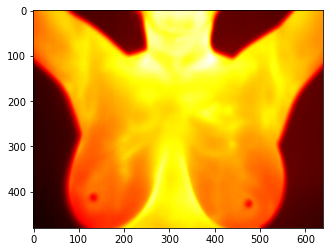

In [24]:
# Imagen original
hola=get_img(path+'train/'+files[1], size_img, display_image = True)

In [25]:
np.max(hola)

0.78683746

In [26]:
np.min(hola)

0.15518688

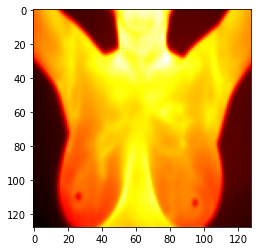

In [27]:
# Imagen resultante
plt.imshow(hola[:,:,0], cmap='hot')

Se leen los archivos y se ordenan en un nuevo arreglo.

In [28]:
# Entrenamiento X_train

# Creamos el arreglo para almacenar las imégenes
# Tendrá tres canales para  aprovechar los pesos preentrenados
# con imágenes de ImageNet
X_train = np.zeros((len(files), size_img, size_img,3))

for i in tqdm(range(len(files))):

  # Leemos y procesamos la imagen con respecto a pos_train
  temp_img = get_img(path+"train/"+files[pos_train[i]], size_img)

  # Almacenamos la imagen obtenida en cada canal
  X_train[i,:,:,0] = temp_img[:,:,0]
  X_train[i,:,:,1] = temp_img[:,:,0]
  X_train[i,:,:,2] = temp_img[:,:,0]

100%|██████████| 3337/3337 [00:16<00:00, 207.19it/s]


In [29]:
X_train.shape

(3337, 128, 128, 3)

In [30]:
# Validación X_test

# Creamos el arreglo para almacenar las imégenes
# Tendrá tres canales para  aprovechar los pesos preentrenados
# con imágenes de ImageNet
X_test = np.zeros((len(files2), size_img, size_img,3))

for i in tqdm(range(len(files2))):

  # Leemos y procesamos la imagen con respecto a pos_train
  temp_img = get_img(path+"test/"+files2[pos_test[i]], size_img)

  # Almacenamos la imagen obtenida en cada canal
  X_test[i,:,:,0] = temp_img[:,:,0]
  X_test[i,:,:,1] = temp_img[:,:,0]
  X_test[i,:,:,2] = temp_img[:,:,0]

100%|██████████| 832/832 [00:06<00:00, 131.31it/s]


In [31]:
X_test.shape

(832, 128, 128, 3)

### GoogleNet

En esta sección se implementa la arquitectura GoogleNet

Esta arquitectura fue propuesta en 2015.

Esta arquitectura propone utilizar la idea de "inception". Con la idea de construir redes convolucionales más profundas se propuso la idea de crear bloques que disminuyeran cada tanto la dimensión de la salida de los bloque convolucionales para posteriromente incrementarlos. La idea de esto era mejorar el entrenemianeto desiminuyendo deliberadamente el tamaño de la salidas. al conseguir esto, el modelo podría entrenarse más facilmente y se podrían realizar modelos con convoluciones más profundas lo cual te´ricamente permite definir modelos más "complejos".

Para la realización de este modelo los autores proponen dos bloques Inception (InceptionV1 e InceptionV2) los cuales realizan convoluciones paralales para su posterior concatenación utilizando el principio previamente. Modificaciones de este modelo fueron propuestos en los últimos años como la InceptionResNet y la InceptionV3. ref: https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf

In [32]:
# importando bibliotecas auxiliares
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
import tensorflow_addons as tfa
from tensorflow.keras import Model, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
# Importando métricas de scikit learn}
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, accuracy_score

In [34]:
# Arreglando el problema de clases desbalanceadas estableciendo un peso por clase en el función de costo
w_p=np.sum(Y_train==0)/Y_train.shape[0]
w_n=np.sum(Y_train==1)/Y_train.shape[0]

In [35]:
# Creando diccionario para establecer el peso de cada clase de salida
class_weights = { 0 : w_n , 1 : w_p }

In [36]:
# definimos dropout
# Esta factor que está definido entre 0 y 1
# es un factor que determina la tasa de unidades que se "apagarán"
# durante el entrenamiento; esto evita el sobreajuste
dropout = 0.2

In [37]:
# Definimos un modelo de incialización
# Esta inicialización ha demostrado ser bastante útil
# para ayudar al modelo a converger más rápido.
# Incialización por he es una técnica que utiliza la destribución probabílistica
# propuesta por He para incializar los pesos de la red neuronal
# Para más información refierase a la coumentación
# de la biblioteca
kernel_init = 'he_normal'

Se define el modulo Inception

In [38]:
# Constantes globales
LRN2D_NORM=True
DATA_FORMAT='channels_last'
USE_BN=True
DROPOUT=0.2

def conv2D_lrn2d(x,filters,kernel_size,strides=(1,1),padding='same',dilation_rate=(1,1),activation='relu',
                 use_bias=True,kernel_initializer='he_normal',bias_initializer='zeros',
                 kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,
                 kernel_constraint=None,bias_constraint=None,lrn2d_norm=LRN2D_NORM,weight_decay=None):
    #l2 normalization
    if weight_decay:
        kernel_regularizer=tf.keras.regularizers.L1(l1=weight_decay)
        bias_regularizer=tf.keras.regularizers.L1(l1=weight_decay)
    else:
        kernel_regularizer=None
        bias_regularizer=None
    x=Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,dilation_rate=dilation_rate,
             activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
             bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
             activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    if lrn2d_norm:
        #batch normalization
        x=BatchNormalization()(x)

    return x

def inception_module(x,params,concat_axis,padding='same',dilation_rate=(1,1),activation='relu',
                     use_bias=True,kernel_initializer='he_normal',bias_initializer='zeros',
                     kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,
                     bias_constraint=None,lrn2d_norm=LRN2D_NORM,weight_decay=None):
    (branch1,branch2,branch3,branch4)=params
    if weight_decay:
        kernel_regularizer=tf.keras.regularizers.L1(l1=weight_decay)
        bias_regularizer=tf.keras.regularizers.L1(l1=weight_decay)
    else:
        kernel_regularizer=None
        bias_regularizer=None
    #1x1
    pathway1=Conv2D(filters=branch1[0],kernel_size=(1,1),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    #1x1->3x3
    pathway2=Conv2D(filters=branch2[0],kernel_size=(1,1),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway2=Conv2D(filters=branch2[1],kernel_size=(3,3),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway2)
    #1x1->5x5
    pathway3=Conv2D(filters=branch3[0],kernel_size=(1,1),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway3=Conv2D(filters=branch3[1],kernel_size=(5,5),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway3)
    #3x3->1x1
    pathway4=MaxPooling2D(pool_size=(3,3),strides=1,padding=padding,data_format=DATA_FORMAT)(x)
    pathway4=Conv2D(filters=branch4[0],kernel_size=(1,1),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway4)

    return concatenate([pathway1,pathway2,pathway3,pathway4],axis=concat_axis)

Se define el modelo GoogleNet

In [39]:
class GoogleNet:
    @staticmethod
    def build(width, height, depth, NB_CLASS):
        INP_SHAPE = (height, width, depth)
        img_input = Input(shape=INP_SHAPE)
        CONCAT_AXIS = 3
        x = conv2D_lrn2d(img_input, 64, (7, 7), 2, padding='same', lrn2d_norm=False)
        x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)
        x = BatchNormalization()(x)

        x = conv2D_lrn2d(x, 64, (1, 1), 1, padding='same', lrn2d_norm=False)

        x = conv2D_lrn2d(x, 192, (3, 3), 1, padding='same', lrn2d_norm=True)
        x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)

        x = inception_module(x, params=[(64,), (96, 128), (16, 32), (32,)], concat_axis=CONCAT_AXIS)  # 3a
        x = inception_module(x, params=[(128,), (128, 192), (32, 96), (64,)], concat_axis=CONCAT_AXIS)  # 3b
        x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)

        x = inception_module(x, params=[(192,), (96, 208), (16, 48), (64,)], concat_axis=CONCAT_AXIS)  # 4a
        x = inception_module(x, params=[(160,), (112, 224), (24, 64), (64,)], concat_axis=CONCAT_AXIS)  # 4b
        x = inception_module(x, params=[(128,), (128, 256), (24, 64), (64,)], concat_axis=CONCAT_AXIS)  # 4c
        x = inception_module(x, params=[(112,), (144, 288), (32, 64), (64,)], concat_axis=CONCAT_AXIS)  # 4d
        x = inception_module(x, params=[(256,), (160, 320), (32, 128), (128,)], concat_axis=CONCAT_AXIS)  # 4e
        x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)

        x = inception_module(x, params=[(256,), (160, 320), (32, 128), (128,)], concat_axis=CONCAT_AXIS)  # 5a
        x = inception_module(x, params=[(384,), (192, 384), (48, 128), (128,)], concat_axis=CONCAT_AXIS)  # 5b
        x = AveragePooling2D(pool_size=(1, 1), strides=1, padding='valid')(x)

        x = Flatten()(x)
        x = Dropout(DROPOUT)(x)
        x = Dense(units=NB_CLASS, activation='linear')(x)
        x = Dense(units=NB_CLASS, activation='sigmoid')(x)

        # Create a Keras Model
        model = Model(inputs=img_input, outputs=[x])
        #model.summary()
        # Save a PNG of the Model Build
        #plot_model(model, to_file='../imgs/GoogLeNet.png')
        # return the constructed network architecture
        return model

In [40]:
# Creando el modelo GooogleNet
rnet = GoogleNet.build(width=X_train.shape[1], height=X_train.shape[2], depth=X_train.shape[3], NB_CLASS=1)

In [41]:
# Visualizando el modelo
rnet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         max_pooling2d[0][0]              
_______________________________________________________________________________________

In [42]:
rnet.output.shape

TensorShape([None, 1])

In [43]:
# Añadiendo un término de regularización para evitar sobreajuste

#L1 = 0.1

#regularizer = tf.keras.regularizers.L1(l1=L1)

#rnet.trainable = True

#for layer in rnet.layers:
#    for attr in ['kernel_regularizer']:
#        if hasattr(layer, attr):
#          setattr(layer, attr, regularizer)

In [44]:
# Se fuerza a la tasa de aprendiza a decaer de forma polinomial para evitar problemas con el entrenamiento
starter_learning_rate = 0.1
end_learning_rate = 0.01
decay_steps = 5
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)

In [45]:
# Definimos el optimizador utilizando el método de Adam
# Este método es una modificación del algoritmo de
# gradiente descendiente
opt=tfa.optimizers.RectifiedAdam(learning_rate=0.01) #,clipvalue=5)
#opt=tf.keras.optimizers.Nadam(learning_rate=0.01 ,clipvalue=5)
#opt=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn) #,clipvalue=5)

In [46]:
# Definiendo las métricas necesarias para dar seguimiento al modelo
METRICS = [
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.5),
  tf.keras.metrics.AUC(name='AUC')
]

In [47]:
# Compilando el modelo
rnet.compile(
    optimizer=opt,
    loss = 'binary_crossentropy',
    metrics=METRICS
)

La métrica de oro será el AUC.



In [48]:
# Con este objeto se guardará el mejor modelo con base a la métrica f1_score
sv = tf.keras.callbacks.ModelCheckpoint(filepath='GoogleNet_weights.h5',monitor='val_AUC', verbose=0, save_best_only=True,
        save_weights_only=False, mode='max', save_freq='epoch')

In [49]:
# Tamaño del batch (se recomienda un batch potencia de 2)
BS = 128

In [50]:
# Entrenando el modelo y almacenando los valores en history_1
history_1 = rnet.fit(X_train, Y_train, batch_size=BS,
                          steps_per_epoch=len(X_train) // BS, validation_data=(X_test, Y_test),
                          epochs=200, verbose=2, class_weight=class_weights, callbacks=[sv])

Epoch 1/200
26/26 - 6s - loss: 0.1809 - accuracy: 0.6725 - precision: 0.3100 - recall: 0.6639 - f1_score: 0.4227 - AUC: 0.7477 - val_loss: 1.1314 - val_accuracy: 0.2776 - val_precision: 0.2776 - val_recall: 1.0000 - val_f1_score: 0.4346 - val_AUC: 0.5496
Epoch 2/200
26/26 - 4s - loss: 0.0946 - accuracy: 0.8825 - precision: 0.6250 - recall: 0.8944 - f1_score: 0.7358 - AUC: 0.9417 - val_loss: 0.6798 - val_accuracy: 0.5913 - val_precision: 0.3786 - val_recall: 0.7359 - val_f1_score: 0.5000 - val_AUC: 0.7118
Epoch 3/200
26/26 - 3s - loss: 0.0424 - accuracy: 0.9452 - precision: 0.7828 - recall: 0.9619 - f1_score: 0.8631 - AUC: 0.9845 - val_loss: 0.7843 - val_accuracy: 0.7224 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_AUC: 0.5498
Epoch 4/200
26/26 - 3s - loss: 0.0445 - accuracy: 0.9508 - precision: 0.7994 - recall: 0.9630 - f1_score: 0.8736 - AUC: 0.9847 - val_loss: 0.7376 - val_accuracy: 0.3245 - val_precision: 0.2875 - val_recall: 0.9697 - val_f1_

In [51]:
# Primera iteración con el AUC de validación más alto
best_iter=np.where(np.max(history_1.history['val_AUC'])==history_1.history['val_AUC'])[0][0]
print(best_iter)

17


In [52]:
# AUC más alto
history_1.history['val_AUC'][best_iter]

0.833084762096405

In [53]:
# Definiendo la función para desplegar la curva ROC
def plot_roc(name, labels, predictions, name_fig):
    fp, tp, _ = roc_curve(labels, predictions)
    auc1 = auc(fp, tp)
    lw=2

    plt.plot(100*fp, 100*tp, linewidth=2, lw=lw, color='darkorange', label='ROC curve (area = %0.2f)' % auc1)
    plt.plot([0, 100], [0, 100], color='navy', lw=lw, linestyle='--',label='Random')
    plt.xlabel('Falsos positivos [%]')
    plt.ylabel('Verdaderos positivos [%]')
    plt.xlim([-5,105])
    plt.ylim([-5,105])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title(name)
    plt.legend(loc="lower right")
    plt.savefig('ROC_'+name_fig+'.png')

In [54]:
# Definiendo función para visualizar curvas de entrenamiento
def display_training_curves(training, validation, title, subplot):   ####2
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('Iteración')
    ax.legend(['Entrenamiento', 'Validación.'])
    ax.scatter(best_iter, validation[best_iter], c='#ff7f0e', s=500)
    bbox = dict(boxstyle="round", fc="0.9")
    ax.annotate("Iteración con AUC más alto", (best_iter, validation[best_iter]), bbox=bbox)
    plt.savefig(str(title)+'.png')

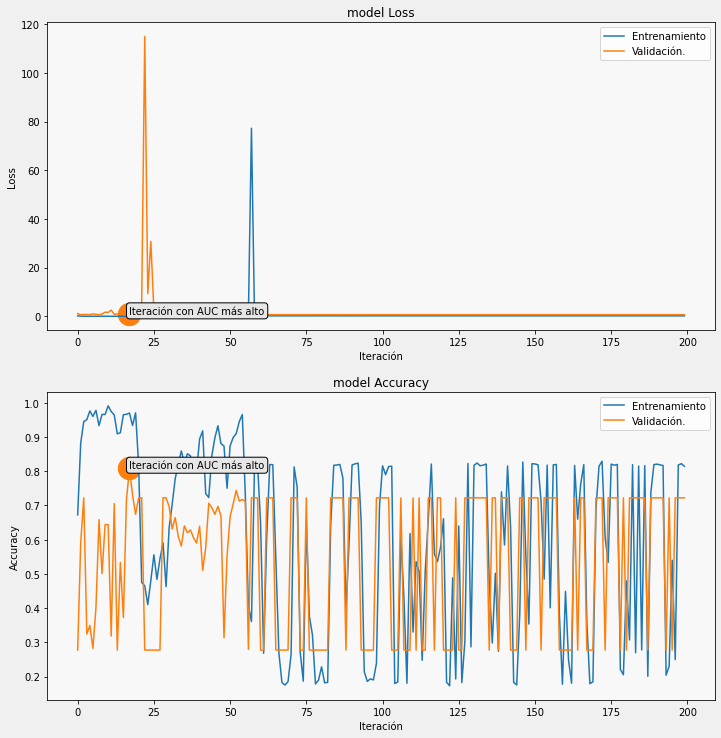

In [55]:
# Desplegando curvas (loss & accuracy)
display_training_curves(history_1.history['loss'], history_1.history['val_loss'], 'Loss', 211)
display_training_curves(history_1.history['accuracy'], history_1.history['val_accuracy'], 'Accuracy', 212)

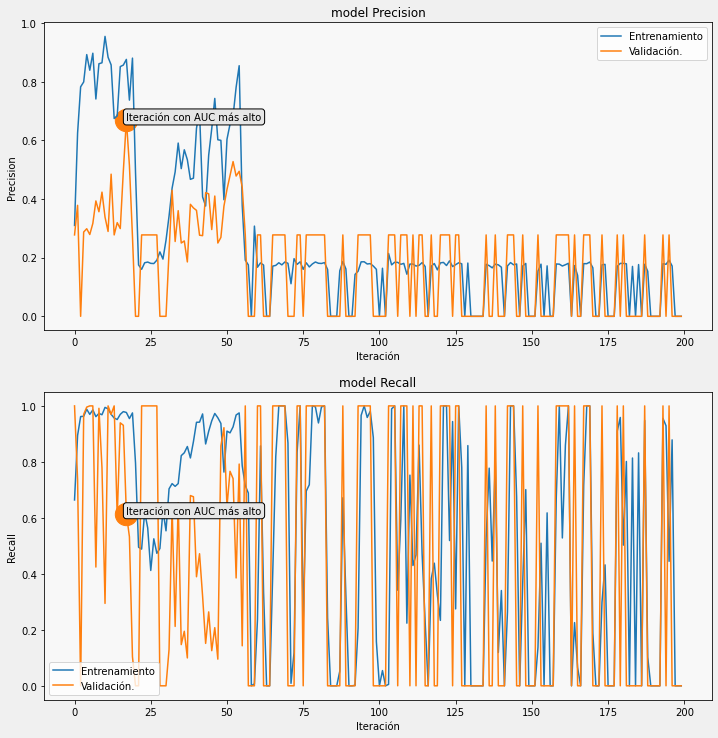

In [56]:
# Desplegando curvas (precision & recall)
display_training_curves(history_1.history['precision'], history_1.history['val_precision'], 'Precision', 211)
display_training_curves(history_1.history['recall'], history_1.history['val_recall'], 'Recall', 212)

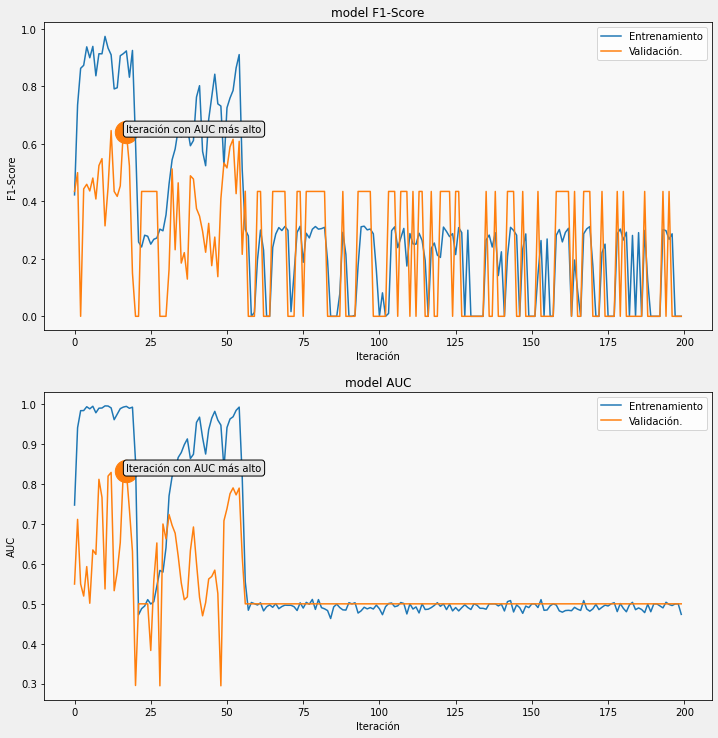

In [57]:
# Desplegando curvas (f1_score & AUC)
display_training_curves(history_1.history['f1_score'], history_1.history['val_f1_score'], 'F1-Score', 211)
display_training_curves(history_1.history['AUC'], history_1.history['val_AUC'], 'AUC', 212)

In [58]:
# Cargamos el modelo con la mejor métrica de AUC en validación
rnet.load_weights("GoogleNet_weights.h5")

In [59]:
# Calculando las predicciones para Red Neuronal
Y_train_pred = (rnet.predict(X_train) > 0.5).astype("int32")
Y_train_proba = rnet.predict(X_train) # Arreglo de probabilidades
Y_test_pred = (rnet.predict(X_test) > 0.5).astype("int32")
Y_test_proba = rnet.predict(X_test) # Arreglo de probabilidades

Lamentablemente Tensorflow subestima la métrica F1-Score y Sobrestima la métrica AUC. Para este trabajo se reportarán los resultados con base en la biblioteca de Scikit-Learn y se utilizará las métricas de TensorFlow sólo como auxiliar para hallar el valor más alto ponderado durante las iteracion o entrenamiento.

Por tanto es posible que algunas gráficas del entrenamiento difieran con los resultados finales de estas dos métricas.

A continuación de realiza una demostración de lo anteriromente descrito.




In [60]:
# Desplegando métrica del rendimiento
print("ResNet50 TensorFlow Metrics")
print()
print("MÉTRICAS EN ENTRENAMIENTO")
metric = tf.keras.metrics.BinaryAccuracy()
metric.update_state(Y_train, Y_train_pred)
print("Accuracy: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.Precision()
metric.update_state(Y_train, Y_train_pred)
print("Precision: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.Recall()
metric.update_state(Y_train, Y_train_pred)
print("Recall: %0.2f%%"%(100*metric.result().numpy()))
metric = tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.5)
metric.update_state(Y_train, Y_train_pred)
print("F1-Score: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.AUC()
metric.update_state(Y_train, Y_train_proba)
print("AUC: %0.2f%%"%(100*metric.result().numpy()))
print()
print("MÉTRICAS EN VALIDACIÓN")
metric = tf.keras.metrics.BinaryAccuracy()
metric.update_state(Y_test, Y_test_pred)
print("Accuracy: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.Precision()
metric.update_state(Y_test, Y_test_pred)
print("Precision: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.Recall()
metric.update_state(Y_test, Y_test_pred)
print("Recall: %0.2f%%"%(100*metric.result().numpy()))
metric = tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.5)
metric.update_state(Y_test, Y_test_pred)
print("F1-Score: %0.2f%%"%(100*metric.result().numpy()))
metric = tf.keras.metrics.AUC()
metric.update_state(Y_test, Y_test_proba)
print("AUC: %0.2f%%"%(100*metric.result().numpy()))
print()
print()
print("ResNet50 SciKit-Learn Metrics")
print()
print("MÉTRICAS EN ENTRENAMIENTO")
print("Accuracy: %0.2f%%"%(100*accuracy_score(Y_train, Y_train_pred)))
print("Precision: %0.2f%%"%(100*precision_score(Y_train, Y_train_pred)))
print("Recall: %0.2f%%"%(100*recall_score(Y_train, Y_train_pred)))
print("F1-Score: %0.2f%%"%(100*f1_score(Y_train, Y_train_pred)))
fp, tp, _ = roc_curve(Y_train, Y_train_proba)
print("AUC: %0.2f%%"%(100*auc(fp, tp)))
print()
print("MÉTRICAS EN VALIDACIÓN")
print("Accuracy: %0.2f%%"%(100*accuracy_score(Y_test, Y_test_pred)))
print("Precision: %0.2f%%"%(100*precision_score(Y_test, Y_test_pred)))
print("Recall: %0.2f%%"%(100*recall_score(Y_test, Y_test_pred)))
print("F1-Score: %0.2f%%"%(100*f1_score(Y_test, Y_test_pred)))
fp, tp, _ = roc_curve(Y_test, Y_test_proba)
print("AUC: %0.2f%%"%(100*auc(fp, tp)))
print()

ResNet50 TensorFlow Metrics

MÉTRICAS EN ENTRENAMIENTO
Accuracy: 90.17%
Precision: 65.02%
Recall: 98.50%
F1-Score: 21.73%
AUC: 97.99%

MÉTRICAS EN VALIDACIÓN
Accuracy: 80.89%
Precision: 66.98%
Recall: 61.47%
F1-Score: 26.57%
AUC: 83.31%


ResNet50 SciKit-Learn Metrics

MÉTRICAS EN ENTRENAMIENTO
Accuracy: 90.17%
Precision: 65.02%
Recall: 98.50%
F1-Score: 78.34%
AUC: 98.71%

MÉTRICAS EN VALIDACIÓN
Accuracy: 80.89%
Precision: 66.98%
Recall: 61.47%
F1-Score: 64.11%
AUC: 84.38%



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  import sys


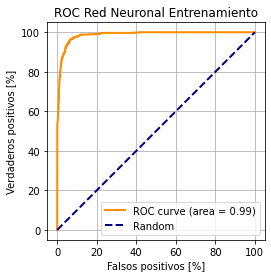

In [61]:
# Curva ROC de entrenamiento
plot_roc('ROC Red Neuronal Entrenamiento', Y_train, Y_train_proba, name_fig='RNET')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  import sys


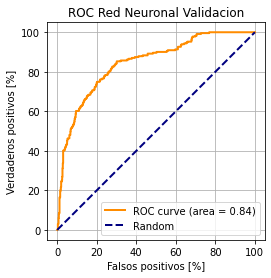

In [62]:
# Curva de Roc de Validación
plot_roc('ROC Red Neuronal Validacion', Y_test, Y_test_proba, name_fig='RNET2')

Finalmente se guarda el modelo completo.

In [63]:
rnet.save('GoogleNet_FULL.h5')

Eliminando archivos innecesarios para guardar la libreta en Kaggle

In [64]:
import shutil

dir_path = './BaseDeDatosFrontales_FINAL_256_bits'

try:
    shutil.rmtree(dir_path)
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))

In [65]:
os.remove("./BaseDeDatosFrontales_FINAL_256_bits.zip")